---
title: "3D Forward Simulation"
authors:
  - id: devincowan
---

```{admonition} Intermediate notebook
:class: caution
This tutorial focusses on intermediate level functionality within SimPEG. Basic functionality within SimPEG is not discussed in detail, as we assume the user is already familiar. 
```

```{admonition} Medium-weight notebook
:class: caution
Requires moderate computational resources. Run-times may exceed several minutes and require up to 8 GB of available RAM.
```

**Keywords:** DC Resistivity, forward simulation, 3D, apparent resistivity, tree mesh.

</br>

**Summary:** Here we use the module [simpeg.electromagnetics.static.resistivity](xref:simpeg#simpeg.electromagnetics.static.resistivity) to simulate 3D DC resistivity data on a tree mesh. Most of the functionality required for this tutorial was presented in the [2.5D Forward Simulation](fwd_dcr_2d.ipynb) tutorial. We strongly urge the reader to work through the 2.5D tutorial prior to working through this one, as we will avoid verbose repitition of content.

</br>

**Learning Objectives:**

- Demonstrating 3D forward simulation of DC resistivity data with SimPEG.
- Specific aspects of designing 3D DC resistivity surveys.
- Generating and plotting models on 3D meshes.
- How to plot 3D data in pseudosection.
- Computational resource considerations for 3D DC resistivity simulations.

## Import Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise. All of the functionality specific to DC resistivity is imported from [simpeg.electromagnetics.static.resistivity](xref:simpeg#simpeg.electromagnetics.static.resistivity).
We also import some useful utility functions from [simpeg.utils](xref:simpeg#simpeg.utils). To simulate DC resistivity data, we need to define our problem geometry on a numerical grid (or mesh).
To generate the mesh, we use the [discretize](https://discretize.simpeg.xyz/en/main) package.

In [1]:
# SimPEG functionality
from simpeg import maps, data
from simpeg.utils import model_builder
from simpeg.utils.io_utils.io_utils_electromagnetics import write_dcip_xyz
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    pseudo_locations,
    plot_pseudosection,
    apparent_resistivity_from_voltage,
    convert_survey_3d_to_2d_lines,
)

try:
    import plotly
    from simpeg.electromagnetics.static.utils.static_utils import plot_3d_pseudosection
    from IPython.core.display import display, HTML

    has_plotly = True
except ImportError:
    has_plotly = False
    pass

# discretize functionality
from discretize import TreeMesh
from discretize.utils import mkvc, active_from_xyz

# Common Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

mpl.rcParams.update({"font.size": 14})

write_output = False  # Optional

## Define the Topography

Surface topography is defined as an (N, 3) [numpy.ndarray](xref:numpy#numpy.ndarray) for 3D simulations.
Here, we create basic topography for the forward simulation.
For user-specific simulations, you may load topography from an XYZ file.

In [2]:
# Generate some topography
x_topo, y_topo = np.meshgrid(
    np.linspace(-2100, 2100, 141), np.linspace(-2100, 2100, 141)
)
z_topo = 410.0 + 140.0 * (1 / np.pi) * (
    np.arctan((x_topo - 500 * np.sin(np.pi * y_topo / 2800) - 400.0) / 200.0)
    - np.arctan((x_topo - 500 * np.sin(np.pi * y_topo / 2800) + 400.0) / 200.0)
)

In [3]:
# Turn into a (N, 3) numpy.ndarray
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
topo_xyz = np.c_[mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)]

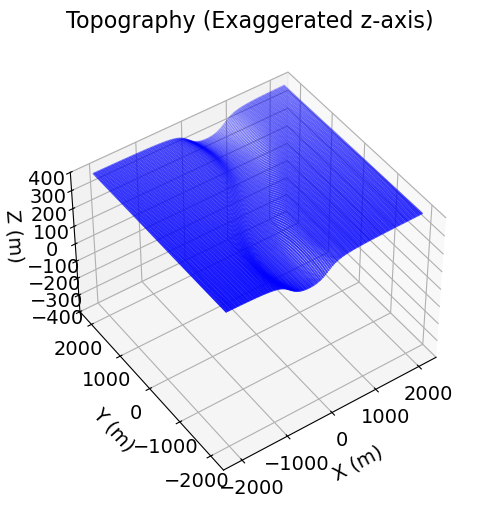

In [4]:
# Plot the topography
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection="3d")
ax.set_zlim([-400, 400])
ax.scatter3D(topo_xyz[:, 0], topo_xyz[:, 1], topo_xyz[:, 2], s=0.25, c="b")
ax.set_box_aspect(aspect=None, zoom=0.85)
ax.set_xlabel("X (m)", labelpad=10)
ax.set_ylabel("Y (m)", labelpad=10)
ax.set_zlabel("Z (m)", labelpad=10)
ax.set_title("Topography (Exaggerated z-axis)", fontsize=16, pad=-20)
ax.view_init(elev=45.0, azim=-125)

## Define the Survey

Descriptions of the elements required to construct DC resistivity surveys were covered in the [2.5D Forward Simulation](fwd_dcr_2d.ipynb) tutorial. The only difference is that for 3D surveys, XYZ locations are required for each electrode location. Once again, there are three approaches one might use to generate the a DC resistivity survey. The final approach will be used to simulate the data for this tutorial.

**Option A: Define each source and its associated receivers directly**

We used this approach in our [2.5D Forward Simulation](fwd_dcr_2d.ipynb) tutorial. For a 3D simulation however, current electrode locations are defined as (3,) [numpy.array](xref:numpy#numpy.array) and the associated set of potential electrode locations are defined as (N, 3) [numpy.ndarray](xref:numpy#numpy.ndarray). This approach is somewhat cumbersome for generating synthetic 3D examples, so we will use a survey generation utility instead (Option C).

**Option B: Survey from ABMN electrode locations**

If we have (N, 3) [numpy.ndarray](xref:numpy#numpy.ndarray) containing the A, B, M and N electrode locations for each datum (loaded or created), we can use the [generate_survey_from_abmn_locations](xref:simpeg#simpeg.electromagnetics.static.utils.generate_survey_from_abmn_locations) to generate the survey automatically.

**Option C: Survey from a set of survey lines**

If the survey is comprised of a set of DC resistivity lines, we can use the [generate_dcip_sources_line](xref:simpeg#simpeg.electromagnetics.static.utils.generate_dcip_sources_line) utility function to define the survey. Here we define the DC resistivity survey that is used simulate the tutorial data. The survey consists of 3 DC resistivity lines that use a dipole-dipole electrode configuration; 1 line along the East-West direction and 2 lines along the North-South direction. Each line is 2000 m in length and has an electrode spacing of 100 m.

In [5]:
# Define the parameters for each survey line
survey_type = "dipole-dipole"
data_type = "volt"
dimension_type = "3D"
end_locations_list = [
    np.r_[-1000.0, 1000.0, 0.0, 0.0],
    np.r_[-600.0, -600.0, -1000.0, 1000.0],
    np.r_[-300.0, -300.0, -1000.0, 1000.0],
    np.r_[0.0, 0.0, -1000.0, 1000.0],
    np.r_[300.0, 300.0, -1000.0, 1000.0],
    np.r_[600.0, 600.0, -1000.0, 1000.0],
]  # [x0, x1, y0, y1]
station_separation = 100.0
num_rx_per_src = 8

# The source lists for each line can be appended to create the source
# list for the whole survey.
source_list = []
for ii in range(0, len(end_locations_list)):
    source_list += generate_dcip_sources_line(
        survey_type,
        data_type,
        dimension_type,
        end_locations_list[ii],
        topo_xyz,
        num_rx_per_src,
        station_separation,
    )

# Define the survey
survey = dc.survey.Survey(source_list)

Here we plot the electrode locations. We use the [unique_electrode_locations](xref:simpeg#simpeg.electromagnetics.static.resistivity.Survey.unique_electrode_locations) method to extract the unique electrode locations from the survey and the [pseudo_locations](xref:simpeg#simpeg.electromagnetics.static.utils.pseudo_locations) utility to extract the pseudo-location.

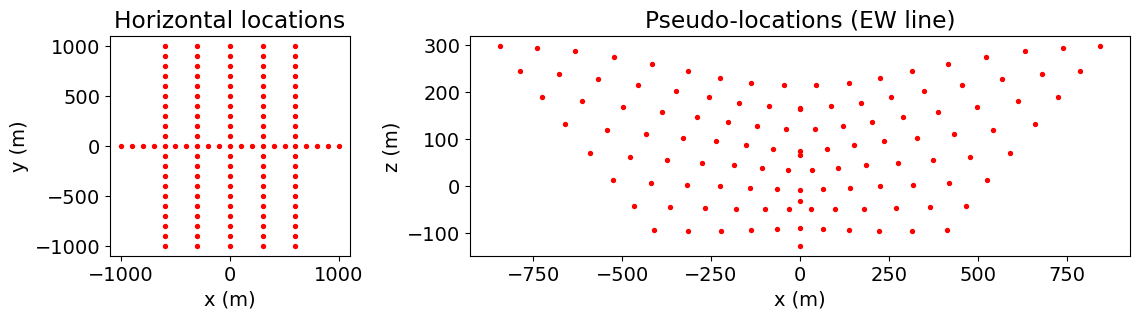

In [6]:
unique_locations = survey.unique_electrode_locations
fig = plt.figure(figsize=(12, 2.75))
ax1 = fig.add_axes([0.1, 0.1, 0.2, 0.8])
ax1.scatter(unique_locations[:, 0], unique_locations[:, 1], 8, "r")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")
ax1.set_title("Horizontal locations")

pseudo_locations_xyz = pseudo_locations(survey)
inds = pseudo_locations_xyz[:, 1] == 0.0
ax2 = fig.add_axes([0.4, 0.1, 0.55, 0.8])
ax2.scatter(pseudo_locations_xyz[inds, 0], pseudo_locations_xyz[inds, -1], 8, "r")
ax2.set_xlabel("x (m)")
ax2.set_ylabel("z (m)")
ax2.set_title("Pseudo-locations (EW line)")
plt.show()

## Design a (Tree) Mesh

**Standard approach for DC/IP:** The standard approach presented in the [2.5D Forward Simulation](fwd_dcr_2d.ipynb) tutorial also applies to forward simulations in 3D. And the same methods are used to refine the tree mesh around electrodes, topography, etc... For 3D simulations however, we may need to consider limitations in computational resources which are not encountered in 2.5D simulations. Because 3D simulations require discretization along a third direction, the number of cells in the mesh is proportional $h^{-3}$; where $h$ is the minimum cell edge length. Therefore the minimum cell size used for 3D simulations is generally coarser than the minimum cell size used for 2.5D simulations.

**Tutorial mesh:** Here, a minimum cell width of 25 m (or 1/4 the minimum electrode spacing) is used within our survey region. The largest electrode spacing was 1000 m, so a the padding was extended at least 3000 m from the survey region. Using the [refine_surface](xref:discretize#discretize.TreeMesh.refine_surface) method, we refine the tree mesh where there is significant topography. And using the [refine_points](xref:discretize#discretize.TreeMesh.refine_points) methods, we refine based on electrodes locations. Visit the [tree mesh](xref:discretize#discretize.TreeMesh) API to see additional refinement methods.

In [7]:
# Defining domain size and minimum cell size
dh = 25.0  # base cell width
dom_width_x = 8000.0  # domain width x
dom_width_y = 8000.0  # domain width y
dom_width_z = 4000.0  # domain width z

# Number of base mesh cells in each direction. Must be a power of 2
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcy = 2 ** int(np.round(np.log(dom_width_y / dh) / np.log(2.0)))  # num. base cells y
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh
hx = [(dh, nbcx)]
hy = [(dh, nbcy)]
hz = [(dh, nbcz)]
mesh = TreeMesh([hx, hy, hz], x0="CCN", diagonal_balance=True)

# Shift top to maximum topography
mesh.origin = mesh.origin + np.r_[0.0, 0.0, z_topo.max()]

# Mesh refinement based on surface topography
k = np.sqrt(np.sum(topo_xyz[:, 0:2] ** 2, axis=1)) < 1200
mesh.refine_surface(topo_xyz[k, :], padding_cells_by_level=[0, 4, 4], finalize=False)

# Mesh refinement near electrodes.
mesh.refine_points(unique_locations, padding_cells_by_level=[6, 6, 4], finalize=False)

# Finalize the mesh
mesh.finalize()

## Define the Active Cells

Simulated geophysical data are dependent on the subsurface distribution of physical property values. As a result, the cells lying below the surface topography are commonly referred to as 'active cells'. And air cells, whose physical property values are fixed, are commonly referred to as 'inactive cells'. Here, the discretize [active_from_xyz](xref:discretize#discretize.utils.active_from_xyz) utility function is used to find the indices of the active cells using the mesh and surface topography. The output quantity is a ``bool`` array.

In [8]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
active_cells = active_from_xyz(mesh, topo_xyz)

# number of active cells
n_active = np.sum(active_cells)

## Models and Mappings

In SimPEG, the term 'model' is not necessarily synonymous with the set of physical property values defined on the mesh. For example, the model may be defined as the logarithms of the physical property values, or be the parameters defining a layered Earth geometry. Models in SimPEG are 1D [numpy.ndarray](xref:numpy#numpy.ndarray) whose lengths are
equal to the number of model parameters.

Classes within the [simpeg.maps](xref:simpeg#simpeg.maps.IdentityMap) module are used to define the mapping that connects the model to the physical property values used in the DC resistivity simulation. Sophisticated mappings can be defined by combining multiple mapping objects. But in the simplest case, the mapping is an identity map and the model consists of the conductivity/resistivity values for all mesh cells (including air).

When simulating DC resistivity data, we have the choice of using resistivity or conductivity to define the Earth's electrical properties. Here, we define the model and its associate mapping for two cases:
1. The model consists of the conductivity values for all active cells
2. The model consists of the log-resistivity values for all active cells

### Define the Model

The units for resistivity are $\Omega m$ and the units for conductivity are $S/m$.

In [9]:
# Define conductivity values in S/m (take reciprocal for resistivities in Ohm m)
air_conductivity = 1e-8
background_conductivity = 1e-2
conductor_conductivity = 1e-1
resistor_conductivity = 1e-3

In [10]:
# Define conductivity model
conductivity_model = background_conductivity * np.ones(n_active)

ind_conductor = model_builder.get_indices_sphere(
    np.r_[-300.0, 0.0, 100.0], 165.0, mesh.cell_centers[active_cells, :]
)
conductivity_model[ind_conductor] = conductor_conductivity

ind_resistor = model_builder.get_indices_sphere(
    np.r_[300.0, 0.0, 100.0], 165.0, mesh.cell_centers[active_cells, :]
)
conductivity_model[ind_resistor] = resistor_conductivity

# Define log-resistivity model
log_resistivity_model = np.log(1 / conductivity_model)

### Mapping from the Model to the Mesh

For our first case, we use the [simpeg.maps.InjectActiveCells](xref:simpeg#simpeg.maps.InjectActiveCells) mapping. This mapping projects quantities defined on the active cells to the entire mesh, and sets a constant value for all inactive cells. **Important:** we set all inactive (air) cells to 1e-8 S/m instead of 0. This is done to ensure that the linear system constructed to solve the PDE for the DC resistivity problem is well-conditioned.

For the second case, we use both the [simpeg.maps.InjectActiveCells](xref:simpeg#simpeg.maps.InjectActiveCells) and [simpeg.maps.ExpMap](xref:simpeg#simpeg.maps.ExpMap) mappings; the latter of which takes the natural exponential. **Important:** we set all inactive (air) cells to 1e8 $\Omega m$ instead of $\infty$. Once again, this is done to ensure that the linear system constructed to solve the PDE for the DC resistivity problem is well-conditioned.

In [11]:
# Conductivity map. Model parameters are conductivities for all active cells.
conductivity_map = maps.InjectActiveCells(mesh, active_cells, air_conductivity)

# Resistivity map. Model parameters are log-resistivities for all active cells.
log_resistivity_map = maps.InjectActiveCells(
    mesh, active_cells, 1 / air_conductivity
) * maps.ExpMap(nP=n_active)

### Plot the Model

To show the geometry of the problem, we plot the conductivity model using the [plot_slice](xref:discretize#discretize.TreeMesh.plot_slice) method.

In [12]:
# Generate a mapping to ignore inactice cells in plot
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

/t40array/ssoler/miniforge3/envs/simpeg-user-tutorials/lib/python3.10/site-packages/discretize/mixins/mpl_mod.py:2152: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  temp_mesh = discretize.TreeMesh(h2d, x2d)


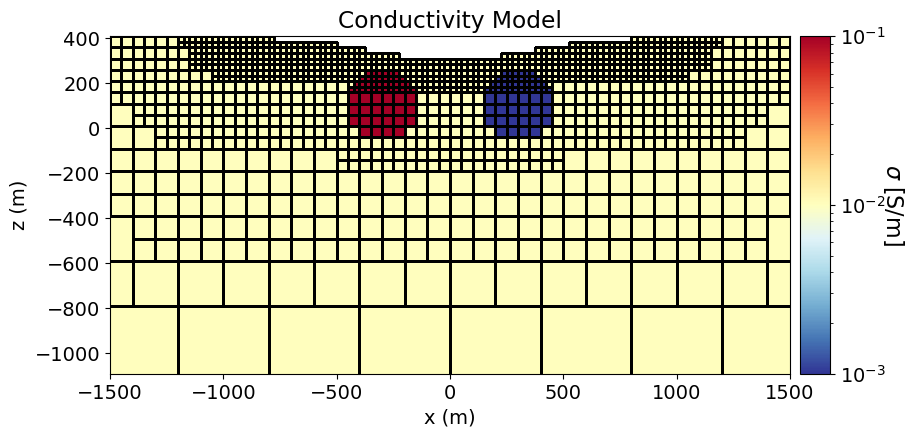

In [13]:
fig = plt.figure(figsize=(10, 4.5))

norm = LogNorm(vmin=1e-3, vmax=1e-1)

ax1 = fig.add_axes([0.15, 0.15, 0.68, 0.75])
mesh.plot_slice(
    plotting_map * conductivity_model,
    ax=ax1,
    normal="Y",
    ind=int(len(mesh.h[1]) / 2),
    grid=True,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)
ax1.set_title("Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")
ax1.set_xlim([-1500, 1500])
ax1.set_ylim([z_topo.max() - 1500, z_topo.max()])

ax2 = fig.add_axes([0.84, 0.15, 0.03, 0.75])
cbar = mpl.colorbar.ColorbarBase(
    ax2, cmap=mpl.cm.RdYlBu_r, norm=norm, orientation="vertical"
)
cbar.set_label("$\sigma$ [S/m]", rotation=270, labelpad=15, size=16)

## Project Electrodes to Discretized Topography

Surface DC resistivity data will not be modeled accurately if the electrodes are modeled as living above or below the surface. It is especially problematic when electrodes are modeled as living in the air. Prior to simulating surface DC resistivity data, we must project the electrodes from their true elevation to the surface of the *discretized* topography. This is done using the [drape_electrodes_on_topography](xref:simpeg#simpeg.electromagnetics.static.resistivity.Survey.drape_electrodes_on_topography) method.

In [14]:
survey.drape_electrodes_on_topography(mesh, active_cells, option="top")

## Define the Forward Simulation

In SimPEG, the physics of the forward simulation is defined by creating an instance of an appropriate simulation class. There are two simulation classes which may be used to simulate 3D DC resistivity data:

- [Simulation3DNodel](xref:simpeg#simpeg.electromagnetics.static.resistivity.Simulation3DNodal), which defines the discrete electric potentials on mesh nodes.
- [Simulation3DCellCentered](xref:simpeg#simpeg.electromagnetics.static.resistivity.Simulation3DCellCentered), which defines the discrete electric potentials at cell centers.

For surface DC resistivity data, the nodal formulation is more well-suited and will be used here. The cell-centered formulation works well for simulating borehole DC resistivity data. Here, we define two simulation objects, one where the model defines the subsurface conductivities, and one where the model defines subsurface log-resistivities. When our model is used to define subsurface electric conductivity, the mapping is set using the ``sigmaMap`` keyword argument. However when our model is used to define subsurface electric resistivity, the mapping must be set using the ``rhoMap`` keyword argument

In [15]:
# DC simulation for a conductivity model
simulation_con = dc.simulation.Simulation3DNodal(
    mesh, survey=survey, sigmaMap=conductivity_map
)

# DC simulation for a log-resistivity model
simulation_res = dc.simulation.Simulation3DNodal(
    mesh, survey=survey, rhoMap=log_resistivity_map
)

## Predict DC Resistivity Data

Once any simulation within SimPEG has been properly constructed, simulated data for a given model vector can be computed using the [dpred](xref:simpeg#simpeg.simulation.BaseSimulation.dpred) method. Note that despite the difference in how we defined the models representing the Earth's electrical properties, the data predicted by both simulations is equivalent.

In [16]:
dpred_con = simulation_con.dpred(conductivity_model)

/t40array/ssoler/miniforge3/envs/simpeg-user-tutorials/lib/python3.10/site-packages/simpeg/simulation.py:197: DefaultSolverWarning: Using the default solver: Pardiso. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)


In [17]:
dpred_res = simulation_res.dpred(log_resistivity_model)

In [18]:
print("MAX ABSOLUTE ERROR = {}".format(np.max(np.abs(dpred_con - dpred_res))))

MAX ABSOLUTE ERROR = 4.440892098500626e-16


## Convert Normalized Voltages to Apparent Conductivities

In this tutorial, the receivers were defined to simulation normalized voltage data. Here, we use the [apparent_resistivity_from_voltage](simpeg#simpeg.electromagnetics.static.utils.apparent_resistivity_from_voltage) utility function to convert the data to apparent resistivities, then take the reciprocal to obtain apparent conductivities.

In [19]:
apparent_conductivity = apparent_resistivity_from_voltage(survey, dpred_con) ** -1

## Plot Data in Pseudosection

### Plot 3D Pseudosection

For general 3D survey configurations, we can use the [plot_3d_pseudosection](simpeg#simpeg.electromagnetics.static.utils.plot_3d_pseudosection) utility function to plot 3D pseudosection data. For large datasets or for surveys with unconventional electrode geometry, interpretation can be challenging if we plot every datum. Here, we plot 3 out of the 6 survey lines to better image anomalous structures. To plot ALL of the data, simply remove the keyword argument *plane_points* when calling *plot_3d_pseudosection*. To use this utility, you must have Python's [plotly](https://plotly.com/python/) package.

In [20]:
# Empty list for plane points
plane_points = []

# 3-points defining the plane for EW survey line
p1, p2, p3 = np.array([-1000, 0, 0]), np.array([1000, 0, 0]), np.array([0, 0, -1000])
plane_points.append([p1, p2, p3])

# NS at x = -300 m
p1, p2, p3 = (
    np.array([-300, -1000, 0]),
    np.array([-300, 1000, 0]),
    np.array([-300, 0, -1000]),
)
plane_points.append([p1, p2, p3])

# NS at x = 300 m
p1, p2, p3 = (
    np.array([300, -1000, 0]),
    np.array([300, 1000, 0]),
    np.array([300, 0, -1000]),
)
plane_points.append([p1, p2, p3])

In [21]:
if has_plotly:
    fig = plot_3d_pseudosection(
        survey,
        apparent_conductivity,
        scale="log",
        units="S/m",
        plane_points=plane_points,
        plane_distance=15,
        marker_opts={"colorscale": "RdYlBu_r"},
    )

    fig.update_layout(
        title_text="Apparent Conductivity",
        title_x=0.5,
        title_font_size=24,
        width=650,
        height=500,
        scene_camera=dict(center=dict(x=0.05, y=0, z=-0.4)),
    )

    #     plotly.io.show(fig)
    html_str = plotly.io.to_html(fig)
    display(HTML(html_str))

else:
    print("INSTALL 'PLOTLY' TO VISUALIZE 3D PSEUDOSECTIONS")

INSTALL 'PLOTLY' TO VISUALIZE 3D PSEUDOSECTIONS


### Plot Individual Lines in 2D Pseudosection

For conventional DC resistivity surveys, the electrodes are located along a set of survey lines. If we know which the survey line associated with each datum, we can parse the 3D survey into a set of 2D survey lines. Then we can plot individual pseudosections for each survey line. Here, we have 6 survey lines, each of which has the same number of data. So assigning a line ID to each datum is easy. You may need to do something more sophisticated in other cases.

In [22]:
# line IDs
n_lines = len(end_locations_list)
n_data_per_line = int(survey.nD / n_lines)
lineID = np.hstack([(ii + 1) * np.ones(n_data_per_line) for ii in range(n_lines)])

Here, we use the [convert_survey_3d_to_2d_lines](simpeg#simpeg.electromagnetics.static.utils.convert_survey_3d_to_2d_lines) to generate the list of 2D surveys.

In [23]:
survey_2d_list, index_list = convert_survey_3d_to_2d_lines(
    survey, lineID, data_type="volt", output_indexing=True
)

Next, we create list of 2D apparent conductivities. Note that if you converted observed data then computed apparent conductivities, you would be doing so assuming 2D survey geometry and the values would not match those on the 3D pseudosection plot!

In [24]:
dobs_2d_list = []
apparent_conductivities_2d = []
for ind in index_list:
    dobs_2d_list.append(dpred_con[ind])
    apparent_conductivities_2d.append(apparent_conductivity[ind])

Now we can use the [plot_2d_pseudosection](simpeg#simpeg.electromagnetics.static.utils.plot_2d_pseudosection) utility function to plot the pseudosection for the desired survey line.

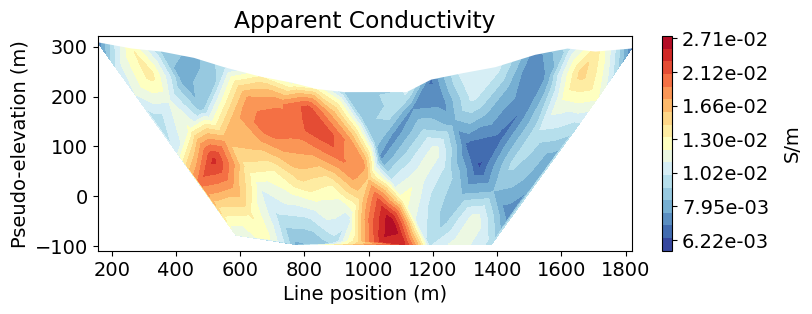

In [25]:
# Line index
line_ind = 0

# Plot apparent conductivity pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    survey_2d_list[line_ind],
    dobs=apparent_conductivities_2d[line_ind],
    plot_type="contourf",
    ax=ax1,
    scale="log",
    cbar_label="S/m",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_title("Apparent Conductivity")
plt.show()

**Optional:** Write DC resistivity data and topography.

In [26]:
if write_output:
    dir_path = os.path.sep.join([".", "fwd_dcr_3d_outputs"]) + os.path.sep
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    # Add 10% Gaussian noise to each datum
    rng = np.random.default_rng(seed=433)
    std = 0.1 * np.abs(dpred_con)
    noise = rng.normal(scale=std, size=len(dpred_con))
    dobs = dpred_con + noise

    # Create dictionary that stores line IDs
    out_dict = {"LINEID": lineID}

    # Create a survey with the original electrode locations
    # and not the shifted ones
    source_list = []
    for ii in range(n_lines):
        source_list += generate_dcip_sources_line(
            survey_type,
            data_type,
            dimension_type,
            end_locations_list[ii],
            topo_xyz,
            num_rx_per_src,
            station_separation,
        )
    survey_original = dc.survey.Survey(source_list)

    # Write out data at their original electrode locations (not shifted)
    data_obj = data.Data(survey_original, dobs=dobs, standard_deviation=std)

    fname = dir_path + "dc_data.xyz"
    write_dcip_xyz(
        fname,
        data_obj,
        data_header="V/A",
        uncertainties_header="UNCERT",
        out_dict=out_dict,
    )

    fname = dir_path + "topo_xyz.txt"
    np.savetxt(fname, topo_xyz, fmt="%.4e")